In [21]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

from azureml.core import Experiment

In [22]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.39


In [23]:
ws = Workspace.from_config()
script_folder = '.'
exp = Experiment(workspace=ws, name='keras-mnist')

In [24]:
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./data/mnist/test-labels.gz')

('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x220aa14fc88>)

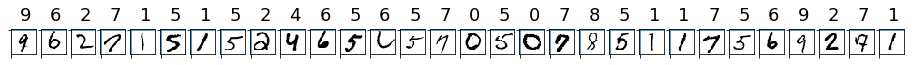

In [25]:
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
plt.show()

In [26]:
ds = ws.get_default_datastore()

In [27]:
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading ./data/mnist\test-images.gz
Uploading ./data/mnist\test-labels.gz
Uploading ./data/mnist\train-images.gz
Uploading ./data/mnist\train-labels.gz
Uploaded ./data/mnist\train-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/mnist\test-labels.gz, 2 files out of an estimated total of 4
Uploaded ./data/mnist\test-images.gz, 3 files out of an estimated total of 4
Uploaded ./data/mnist\train-images.gz, 4 files out of an estimated total of 4


$AZUREML_DATAREFERENCE_b44ddec9bbf44472a156ef1881ac987d

In [28]:
compute_target = ws.compute_targets['prodmod-compute1']
print(compute_target.get_status().serialize())

{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-05-21T01:28:27.531000+00:00', 'errors': None, 'creationTime': '2019-05-20T21:19:08.973390+00:00', 'modifiedTime': '2019-05-20T21:20:48.008942+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT600S'}, 'vmPriority': 'LowPriority', 'vmSize': 'STANDARD_D2_V2'}


In [34]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ds.path('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.001
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target, 
                 pip_packages=['keras', 'matplotlib'],
                 entry_script='keras_mnist.py', 
                 use_gpu=False)

framework_version is not specified, defaulting to version 1.13.


In [35]:
print(ds.path('mnist').as_mount())

$AZUREML_DATAREFERENCE_b848dfce349a4af3b849ff53967b2532


In [36]:
run = exp.submit(est)

In [37]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [38]:
run.wait_for_completion(show_output=True)

RunId: keras-mnist_1558559323_a80c34ee

Streaming azureml-logs/20_image_build_log.txt

2019/05/22 21:08:49 Downloading source code...
2019/05/22 21:08:51 Finished downloading source code
2019/05/22 21:08:52 Using acb_vol_4cea97b0-7d0e-4e89-9eba-8fb58d28be9f as the home volume
2019/05/22 21:08:52 Creating Docker network: acb_default_network, driver: 'bridge'
2019/05/22 21:08:52 Successfully set up Docker network: acb_default_network
2019/05/22 21:08:52 Setting up Docker configuration...
2019/05/22 21:08:53 Successfully set up Docker configuration
2019/05/22 21:08:53 Logging in to registry: prodmod3d2bdaf0.azurecr.io
2019/05/22 21:08:54 Successfully logged into prodmod3d2bdaf0.azurecr.io
2019/05/22 21:08:54 Executing step ID: acb_step_0. Working directory: '', Network: 'acb_default_network'
2019/05/22 21:08:54 Scanning for dependencies...
2019/05/22 21:08:54 Successfully scanned dependencies
2019/05/22 21:08:54 Launching container with name: acb_step_0
Sending build context to Docker dae

  ERROR: Complete output from command /azureml-envs/azureml_3a9f7c22f1f9ad565a2165ed411b8f30/bin/python -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-p35hcefn/horovod/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-v23_cju3 --python-tag cp36:
  ERROR: 
  Installed /tmp/pip-install-p35hcefn/horovod/.eggs/psutil-5.6.2-py3.6-linux-x86_64.egg
  Searching for cloudpickle
  Reading https://pypi.org/simple/cloudpickle/
  Best match: cloudpickle 1.1.1
  Processing cloudpickle-1.1.1-py2.py3-none-any.whl
  Installing cloudpickle-1.1.1-py2.py3-none-any.whl to /tmp/pip-install-p35hcefn/horovod/.eggs
  
  Installed /tmp/pip-install-p35hcefn/horovod/.eggs/cloudpickle-1.1.1-py3.6.egg
  Searching for cffi>=1.4.0
  Reading https://pypi.org/simple/cffi/
  Best match: cffi 1.12.3
  Processing cffi-1.12.3-cp36-cp36m-manylinux1_x86_

  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: /root/.cache/pip/wheels/ee/98/38/46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: /root/.cache/pip/wheels/17/08/ec/22b464874958c3fc91e1a75748fae2220eb704a8b1035f9a03
  Stored in directory: /root/.cache/pip/wheels/45/cb/7e/ce6e6062c69446e39e328170524ca8213498bc66a74c6a210b
  Stored in directory: /root/.cache/pip/wheels/f2/9a/90/de94f8556265ddc9d9c8b271b0f63e57b26fb1d67a45564511
Successfully built pyyaml termcolor absl-py gast psutil pathspec pycparser
Failed to build horovod
  Running setup.py install for horovod: started
    Running setup.py install for horovod: finished with status 'done'

#
# To activate this environment,

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
2019-05-22 21:24:21.038379: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2

{'runId': 'keras-mnist_1558559323_a80c34ee',
 'target': 'prodmod-compute1',
 'status': 'Completed',
 'startTimeUtc': '2019-05-22T21:22:42.216562Z',
 'endTimeUtc': '2019-05-22T21:26:20.084358Z',
 'properties': {'azureml.runsource': 'experiment',
  'AzureML.DerivedImageName': 'azureml/azureml_11f5953d7271da9d4f3f3a06d0360d16',
  'ContentSnapshotId': 'f834e662-5a00-4df5-86c9-bd08314ec289',
  'azureml.git.repository_uri': 'https://github.com/rajkorde/prodmod.git',
  'azureml.git.branch': 'azureml',
  'azureml.git.commit': '328cc96d2a5591c66da43cf94f91cdb94af2807a',
  'azureml.git.dirty': 'True',
  'azureml.git.build_id': None,
  'azureml.git.build_uri': None,
  'mlflow.source.git.branch': 'azureml',
  'mlflow.source.git.commit': '328cc96d2a5591c66da43cf94f91cdb94af2807a',
  'mlflow.source.git.repoURL': 'https://github.com/rajkorde/prodmod.git'},
 'runDefinition': {'script': 'keras_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_8f3b366f7e524ef5b0dce5e028e72f1d',
   '

In [39]:
run.get_details()

{'runId': 'keras-mnist_1558559323_a80c34ee',
 'target': 'prodmod-compute1',
 'status': 'Completed',
 'startTimeUtc': '2019-05-22T21:22:42.216562Z',
 'endTimeUtc': '2019-05-22T21:26:20.084358Z',
 'properties': {'azureml.runsource': 'experiment',
  'AzureML.DerivedImageName': 'azureml/azureml_11f5953d7271da9d4f3f3a06d0360d16',
  'ContentSnapshotId': 'f834e662-5a00-4df5-86c9-bd08314ec289',
  'azureml.git.repository_uri': 'https://github.com/rajkorde/prodmod.git',
  'azureml.git.branch': 'azureml',
  'azureml.git.commit': '328cc96d2a5591c66da43cf94f91cdb94af2807a',
  'azureml.git.dirty': 'True',
  'azureml.git.build_id': None,
  'azureml.git.build_uri': None,
  'mlflow.source.git.branch': 'azureml',
  'mlflow.source.git.commit': '328cc96d2a5591c66da43cf94f91cdb94af2807a',
  'mlflow.source.git.repoURL': 'https://github.com/rajkorde/prodmod.git'},
 'runDefinition': {'script': 'keras_mnist.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_8f3b366f7e524ef5b0dce5e028e72f1d',
   '

In [40]:
run.get_metrics()

{'Loss': [0.2122982455440797,
  0.09029250176191757,
  0.06523389951262895,
  0.05053424794357852,
  0.0402885623213236,
  0.03293824040455093,
  0.027635724365171654,
  0.022073703143247532,
  0.01984601585372237,
  0.01767364969258426,
  0.013689749672128427,
  0.013309568277163942,
  0.011129355879044598,
  0.011145122312172158,
  0.009299509435572437,
  0.008739376774609819,
  0.007899390405646637,
  0.006869527731398436,
  0.006824859978767686,
  0.006908383808148102],
 'Accuracy': [0.9365166663875183,
  0.9727166687448819,
  0.9806166694064935,
  0.985166670680046,
  0.9883166701594989,
  0.990783337255319,
  0.9924000038703282,
  0.9936666697760423,
  0.9944333368043105,
  0.9951500025888284,
  0.996116669724385,
  0.9963833356897036,
  0.9970500023166339,
  0.9970000021656354,
  0.9975833352903525,
  0.9979833348592122,
  0.9980000016093254,
  0.9982166681687037,
  0.9984666679302852,
  0.9985333346327145],
 'Final test loss': 0.15107402422046098,
 'Final test accuracy': 0.9826

In [41]:
run.get_file_names()

['Accuracy vs Loss.png',
 'azureml-logs/20_image_build_log.txt',
 'azureml-logs/55_batchai_execution.txt',
 'azureml-logs/60_control_log.txt',
 'azureml-logs/80_driver_log.txt',
 'logs/azureml/azureml.log',
 'outputs/model/model.h5',
 'outputs/model/model.json']

In [42]:
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

In [49]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

Using TensorFlow backend.


Keras version: 2.2.4
Tensorflow version: 1.13.1


In [50]:
from keras.models import model_from_json

In [52]:
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

Instructions for updating:
Colocations handled automatically by placer.


In [53]:
loaded_model.load_weights("model/model.h5")

In [54]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [69]:
y_test_ohe = one_hot_encode(y_test, 10)

In [70]:
y_hat = np.argmax(loaded_model.predict(X_test), axis=1)

In [71]:
print('labels:  \t', y_test[:30])
print('predictions:\t', y_hat[:30])

labels:  	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
predictions:	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [72]:
print("Accuracy on the test set:", np.average(y_hat == y_test))

Accuracy on the test set: 0.9826


In [73]:
print(run.get_details()['runDefinition']['arguments'])

['--data-folder', '$AZUREML_DATAREFERENCE_8f3b366f7e524ef5b0dce5e028e72f1d', '--batch-size', '50', '--first-layer-neurons', '300', '--second-layer-neurons', '100', '--learning-rate', '0.001']


In [74]:
model = run.register_model(model_name='keras_mlp_mnist', model_path='outputs/model')

In [75]:
%%writefile score.py
import json
import numpy as np
import os
from keras.models import model_from_json

from azureml.core.model import Model

def init():
    global model
    
    model_root = Model.get_model_path('keras-mlp-mnist')
    # load json and create model
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

Writing score.py


In [76]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('tensorflow')
cd.add_conda_package('keras')
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

'myenv.yml'

In [77]:
cd.serialize_to_string()

'# Conda environment specification. The dependencies defined in this file will\r\n# be automatically provisioned for runs with userManagedDependencies=False.\r\n\n# Details about the Conda environment file format:\r\n# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually\r\n\nname: project_environment\ndependencies:\n  # The python interpreter version.\r\n  # Currently Azure ML only supports 3.5.2 and later.\r\n- python=3.6.2\n\n- pip:\n  - azureml-defaults==1.0.39.*\n- tensorflow\n- keras\n'

In [78]:
from azureml.core.webservice import AciWebservice

In [80]:
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, auth_enabled=True, memory_gb=1, tags={'name':'mnist', 'framework': 'keras'},
                                              description='Keras MLP on MNIST')

In [81]:
from azureml.core.image import ContainerImage

In [82]:
imgconfig = ContainerImage.image_configuration(execution_script='score.py', runtime='python', conda_file='myenv.yml')

In [83]:
from azureml.core.webservice import Webservice

In [88]:
service = Webservice.deploy_from_model(workspace=ws, name='keras-mnist-svc', deployment_config=aciconfig, models=[model], image_config=imgconfig)

WebserviceException: Error, there is already a service with name keras-mnist-svc found in workspace prodmod

In [89]:
service.wait_for_deployment(show_output=True)

Failed

WebserviceException: Service deployment polling reached non-successful terminal state, current service state: Failed
Error:
{
  "code": "AciDeploymentFailed",
  "message": "Aci Deployment failed with exception: Your container application crashed. This may be caused by errors in your scoring file's init() function.\nPlease check the logs for your container instance: keras-mnist-svc. From the AML SDK, you can run print(service.get_logs()) if you have service object to fetch the logs. \nYou can also try to run image prodmod3d2bdaf0.azurecr.io/keras-mnist-svc:1 locally. Please refer to http://aka.ms/debugimage#service-launch-fails for more information.",
  "details": [
    {
      "code": "CrashLoopBackOff",
      "message": "Your container application crashed. This may be caused by errors in your scoring file's init() function.\nPlease check the logs for your container instance: keras-mnist-svc. From the AML SDK, you can run print(service.get_logs()) if you have service object to fetch the logs. \nYou can also try to run image prodmod3d2bdaf0.azurecr.io/keras-mnist-svc:1 locally. Please refer to http://aka.ms/debugimage#service-launch-fails for more information."
    }
  ]
}